In [2]:
import xarray as xr, glob, cartopy, matplotlib.pyplot as plt, pandas as pd, regionmask, geopandas as gpd, datetime
from IPython.display import clear_output

mapproj = cartopy.crs.PlateCarree()
xn,xx,yn,yx = [-86,-55,10,27]

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/hurricane-melissa/"

ERROR 1: PROJ: proj_create_from_database: Open of /rds/general/user/cb2714/home/miniforge3/envs/wwa/share/proj failed


# Potential intensity during October

In [ ]:
ibtracs = pd.read_csv("ibtracs-melissa.csv", parse_dates = ["ISO_TIME"], index_col = "ISO_TIME").rename(columns = {"LAT" : "lat", "LON" : "lon"}).sort_index()
rammb = pd.read_csv("rammb-track-melissa.csv", parse_dates = ["Synoptic_Time"], index_col = "Synoptic_Time").rename(columns = {"Latitude" : "lat", "Longitude" : "lon"}).sort_index()
# rammb = rammb.loc[slice(ibtracs.index[-1], None)].iloc[1:,:]

In [102]:
ibtracs = ibtracs.loc[slice(None, rammb.index[0])].iloc[:-1,:]

In [97]:
pi_daily = xr.open_dataset(fpath+"potential-intensity/era5/pi-peryear/pi_era5_daily_2025-10.nc").vmax#.sel(lon = slice(None, -60), lat = slice(None, 12))

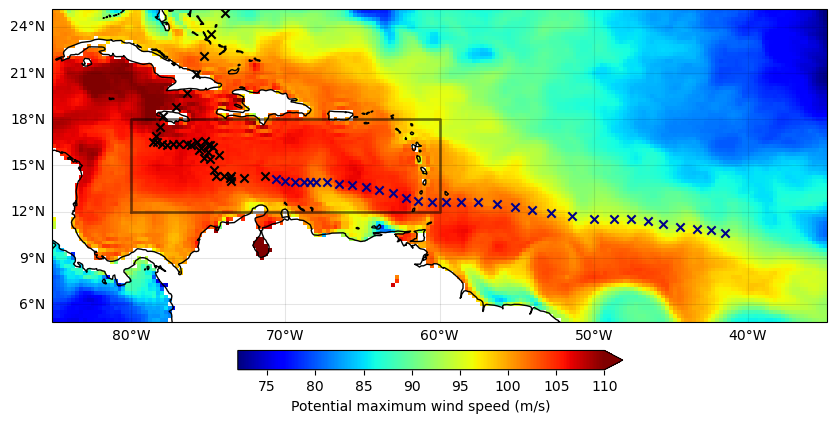

In [103]:
fig, ax = plt.subplots(subplot_kw = {"projection" : mapproj}, figsize = (10,5), dpi = 100)

pi_daily.mean("time").plot(ax = ax, cmap = "jet", vmax = 110,
                           cbar_kwargs = {"location" : "bottom", "label" : "Potential maximum wind speed (m/s)", "fraction" : 0.05, "pad" : 0.075})

ax.scatter(ibtracs.lon, ibtracs.lat, marker = "x", color = "darkblue")
ax.scatter(rammb.lon, rammb.lat, marker = "x", color = "k")

ax.coastlines()
ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["left", "bottom"])

bxn,bxx,byn,byx = [-80,-60,12,18]
ax.plot([bxn,bxn,bxx,bxx,bxn], [byn,byx,byx,byn,byn], color = "k", lw = 2, alpha = 0.5)

In [44]:
px_daily = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.lon, df.lat), crs = mapproj)

## Compare spatial definitions

In [ ]:
pi = xr.open_dataset(fpath+"potential-intensity/pi-era5.nc").vmax

ts60w = pi.sel(lon = slice(bxn,bxx), lat = slice(byx,byn)).mean(["lat", "lon"])
ts70w = pi.sel(lon = slice(bxn,-70), lat = slice(byx,byn)).mean(["lat", "lon"])

In [121]:
ts60w.to_netcdf("data/ts-daily_pi_era5.nc")

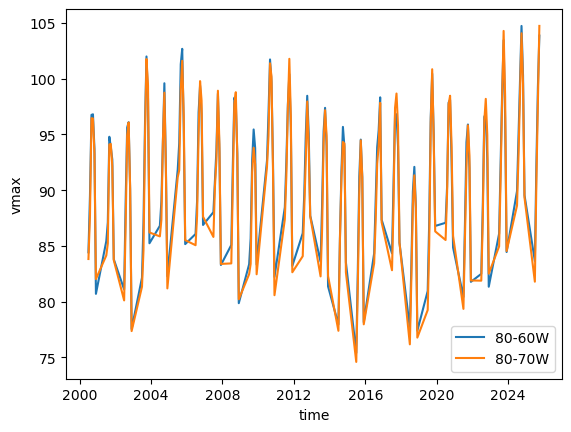

In [120]:
ts60w.sel(time = slice("2000",None)).plot()
ts70w.sel(time = slice("2000",None)).plot()

plt.legend(["80-60W", "80-70W"])

## Compare definitions


In [148]:
ts_oct = ts60w.groupby("time.month")[10].resample(time = "YS").max()
ts_son = ts60w.sel(time = ts60w.time.dt.month.isin([9,10,11])).resample(time = "YS").max()

In [149]:
ts_sonmax = xr.concat([ts60w.sel(time = str(y)).idxmax() for y in range(1940,2026)], "time")

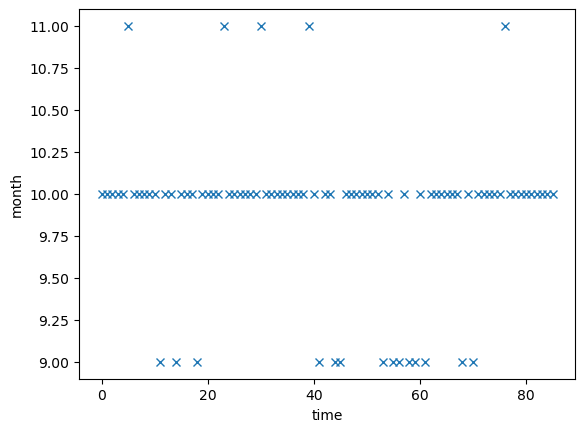

In [150]:
ts_sonmax.dt.month.plot(ls = "", marker = "x")

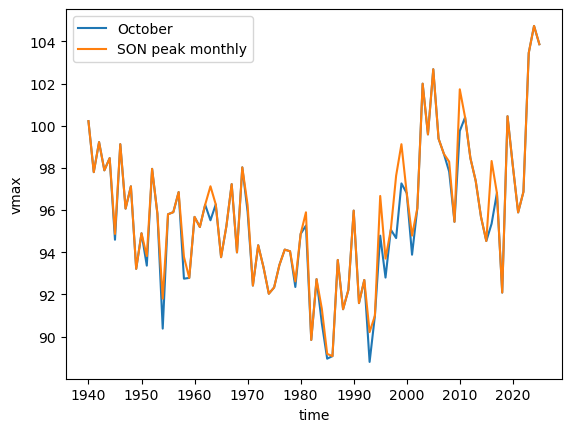

In [152]:
ts_oct.plot()
ts_son.plot()
plt.legend(["October", "SON peak monthly"])

## Create time series


In [161]:
ts_son = ts60w.sel(time = ts60w.time.dt.month.isin([9,10,11])).resample(time = "YS").max()
ts_son = ts_son.assign_coords(time = ts_son.time.dt.year).rename(time = "year").to_dataframe()

# csv for climate explorer
csv_fnm = "hurricane-melissa_pi_era5"
csv_fullpath = "ts/"+csv_fnm+".dat"
if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create header lines for upload to Climate Explorer 
str1 = "# contact :: ERA5 maximum monthly potential intensity in the Caribbean - Hurricane Melissa, c.barnes22@imperial.ac.uk"
str2 = "# vmax [m/s] Annual maximum of monthly potential intensity averaged over 80-60W, 12-18N at "+csv_fnm+".dat"
head = "# year vmax"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
ts_son.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

# Other SSTs

In [ ]:
xr.open_dataset("/rds/general/user/cb2714/home/wwa/10_misc/detrended_nino34/sst.mnmean.nc")

# Correlation between precip and PI

In [164]:
pi = pd.read_csv("ts/hurricane-melissa_pi_era5.dat", comment = "#", sep = " ", header = None, names = ["year", "pi"], index_col = "year")

In [181]:
pr = pd.read_csv("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/hurricane-melissa/precip/obs_timeseries/era_2day_cb.csv", index_col = "year")

In [182]:
df = pd.merge(pr, pi, left_index = True, right_index = True)
df.corr()

,tp,pi
tp,1.000000,0.114823
pi,0.114823,1.000000


<Axes: xlabel='year'>

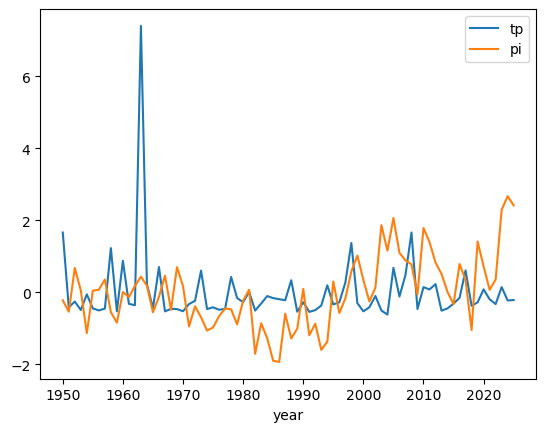

In [183]:
((df - df.mean()) / df.std()).plot()


# Trends in sub-indices

In [2]:
ds = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/hurricane-melissa/potential-intensity/pivars-era5.nc")
pi = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/hurricane-melissa/potential-intensity/pi-era5.nc")
ds = xr.merge([ds, pi])

In [11]:
bxn,bxx,byn,byx = [-80,-60,12,18]

ts = ds.sel(lon = slice(bxn,bxx), lat = slice(byx,byn)).mean(["lon", "lat"]).groupby("time.month")[10]

ts["t"] = ts.t.mean(["p"])
ts["q"] = ts.q.mean(["p"])

In [ ]:
ds.sst.sel(lon = slice(bxn,bxx), lat = slice(byx,byn)).mean(["lon", "lat"]).to_netcdf("data/era5_sst_monthly.nc")

In [13]:
ds.sst.sel(lon = slice(bxn,bxx), lat = slice(byx,byn)).mean(["lon", "lat"])

<xarray.DataArray 'sst' (time: 514)> Size: 2kB
array([28.000074, 28.41944 , 28.74116 , 28.91564 , 28.656096, 27.787529,
       27.724926, 28.307758, 28.708755, 28.681284, 28.515545, 27.889845,
       27.958677, 28.208378, 28.455885, 28.661013, 28.488325, 27.623972,
       27.44236 , 28.23308 , 28.715849, 28.700525, 28.36464 , 27.556616,
       27.845913, 28.45995 , 28.7933  , 29.005877, 28.35557 , 27.492027,
       27.656364, 28.347256, 28.290815, 28.421812, 28.194242, 27.744429,
       27.482618, 28.385366, 28.67563 , 28.974419, 28.23619 , 27.291351,
       27.951649, 28.270159, 28.589739, 28.858124, 28.583046, 27.743906,
       27.949127, 28.540045, 28.569872, 29.052912, 28.40278 , 27.557884,
       27.633675, 28.194103, 28.486788, 28.519205, 28.124315, 27.373812,
       27.432358, 28.1676  , 28.641363, 28.572725, 27.966125, 27.42069 ,
       28.116817, 28.314716, 29.077961, 28.713064, 28.515173, 27.518713,
       28.07421 , 28.522142, 29.007   , 29.124313, 28.65255 , 27.520618,
       27.913065, 28.560219, 28.748732, 28.919832, 28.739037, 27.87721 ,
       27.815786, 28.3311  , 28.606144, 28.064688, 27.842476, 27.08317 ,
       27.861288, 28.493067, 28.915245, 28.770174, 28.194365, 27.347912,
       27.355795, 27.982649, 28.348549, 28.63494 , 28.072073, 27.221676,
       27.759846, 28.310467, 28.838001, 28.8478  , 28.401827, 27.472687,
       28.518808, 28.716572, 28.960293, 28.606037, 28.18313 , 27.512072,
       27.76554 , 28.271923, 28.597534, 28.566784, 28.25188 , 27.672125,
...
       28.341694, 28.668442, 29.3269  , 29.41904 , 28.928604, 28.151705,
       28.50591 , 28.76723 , 28.892193, 29.06145 , 28.549864, 27.651075,
       28.03118 , 28.826996, 29.418533, 29.153347, 28.642855, 27.445269,
       28.22755 , 28.512194, 29.054155, 29.028221, 28.768158, 27.98862 ,
       29.088886, 29.520252, 29.872868, 29.43271 , 28.573622, 27.546337,
       28.498672, 28.971388, 29.427834, 29.294113, 28.791298, 27.877924,
       28.252188, 28.599943, 29.055502, 29.160042, 28.804855, 28.130737,
       27.999702, 28.543709, 29.103231, 29.083458, 28.589565, 27.666279,
       27.759432, 28.322535, 28.711565, 28.93135 , 28.681063, 27.840845,
       27.552275, 28.333033, 29.024027, 29.202702, 28.618273, 27.711655,
       28.318497, 28.819693, 29.11886 , 29.058159, 29.042198, 28.156889,
       28.35907 , 28.888577, 29.434011, 29.16737 , 28.766306, 28.07872 ,
       27.681932, 28.163025, 28.71793 , 28.71458 , 28.421719, 27.469334,
       28.089846, 28.698654, 29.408503, 29.41384 , 28.90519 , 28.284002,
       28.621756, 29.035976, 29.59693 , 29.375473, 28.703184, 28.026169,
       28.056927, 28.636837, 29.220972, 29.27459 , 28.688864, 27.909594,
       28.155367, 28.705832, 29.449877, 29.227633, 28.695112, 27.635496,
       28.79784 , 29.462936, 30.042334, 30.294735, 29.494284, 28.41307 ,
       29.202852, 29.635073, 30.14061 , 30.29707 , 29.679976, 28.81031 ,
       28.360817, 29.173336, 29.725239, 29.95154 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1940-07-01 1940-08-01 ... 2025-10-01

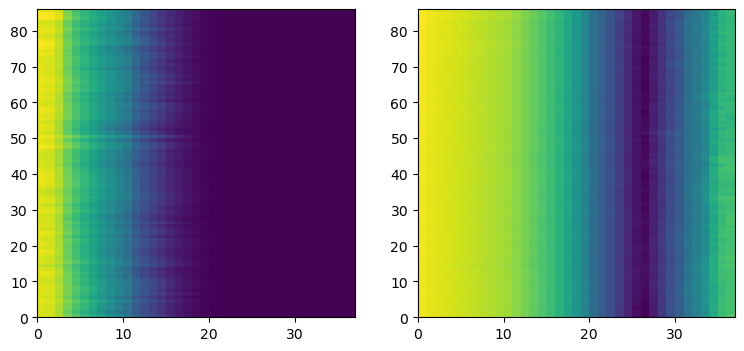

In [224]:
fig, axs = plt.subplots(ncols = 2, figsize = (9,4))
axs[0].pcolormesh(ts.q)
axs[1].pcolormesh(ts.t)

In [229]:
ts_std = (ts - ts.mean("time")) / ts.std("time")

Text(0.5, 1.0, 'Mean atmospheric specific humidity vs PI')

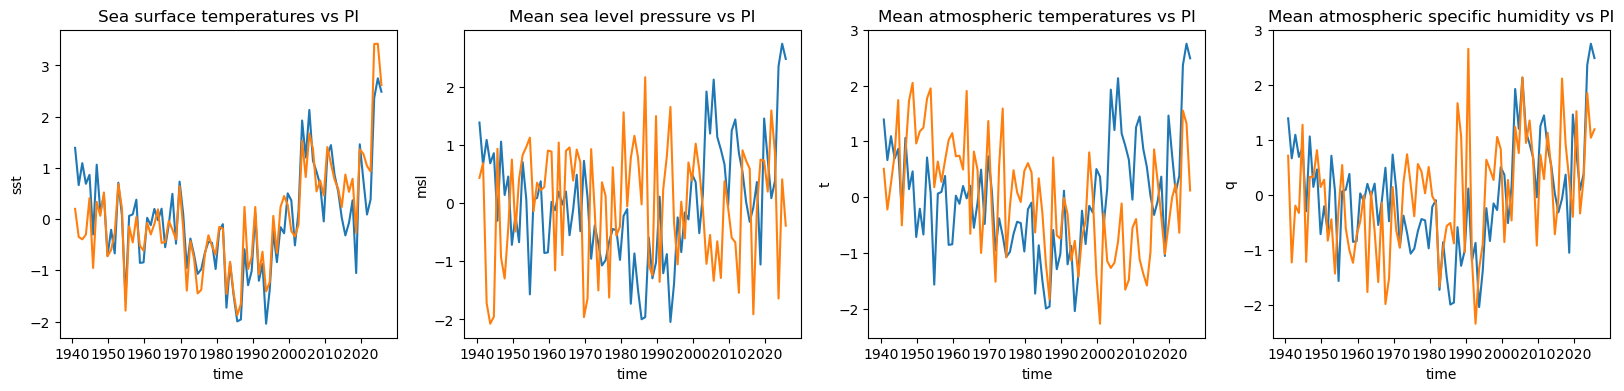

In [234]:
fig, axs = plt.subplots(ncols = 4, figsize = (20,4))

ax = axs[0]
ts_std.vmax.plot(ax = ax, label = "vmax")
ts_std.sst.plot(ax = ax, label = "sst")
ax.set_title("Sea surface temperatures vs PI")

ax = axs[1]
ts_std.vmax.plot(ax = ax, label = "vmax")
ts_std.msl.plot(ax = ax, label = "msl")
ax.set_title("Mean sea level pressure vs PI")

ax = axs[2]
ts_std.vmax.plot(ax = ax, label = "vmax")
ts_std.t.plot(ax = ax, label = "t")
ax.set_title("Mean atmospheric temperatures vs PI")

ax = axs[3]
ts_std.vmax.plot(ax = ax, label = "vmax")
ts_std.q.plot(ax = ax, label = "q!")
ax.set_title("Mean atmospheric specific humidity vs PI")

In [247]:
ts.drop_vars("p").to_dataframe().corr().round(3)

,msl,q,sst,t,vmax
msl,1.000,-0.601,-0.297,-0.231,-0.376
q,-0.601,1.000,0.544,0.091,0.465
sst,-0.297,0.544,1.000,0.176,0.888
t,-0.231,0.091,0.176,1.000,0.120
vmax,-0.376,0.465,0.888,0.120,1.000


## Check effect of starting time

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 514, lat: 81, lon: 201, p: 37)
Coordinates:
  * lon      (lon) float64 2kB -85.0 -84.75 -84.5 -84.25 ... -35.5 -35.25 -35.0
  * lat      (lat) float64 648B 25.0 24.75 24.5 24.25 24.0 ... 5.75 5.5 5.25 5.0
  * p        (p) float64 296B 1e+03 975.0 950.0 925.0 900.0 ... 5.0 3.0 2.0 1.0
  * time     (time) datetime64[ns] 4kB 1940-07-01 1940-08-01 ... 2025-10-01
Data variables:
    msl      (time, lat, lon) float32 33MB ...
    q        (time, p, lat, lon) float32 1GB ...
    sst      (time, lat, lon) float32 33MB ...
    t        (time, p, lat, lon) float32 1GB ...
Attributes:
    CDI:          Climate Data Interface version 1.9.0 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Wed Oct 29 12:02:32 2025: cdo merge /rds/general/user/cb271...
    CDO:          Climate Data Operators version 1.9.0 (http://mpimet.mpg.de/...